# FoCus Dataset

In [1]:
DATASET = "FoCus"
SET = "train"           #train,   valid   
MAX_LENGTH = 110

In [2]:
import pandas as pd
import json

with open(f'./datasets/{DATASET}/{SET}_focus.json') as f:
    data = json.load(f)

In [3]:
def convertToDialogue(my_list):
    formatted_string = ""
    for index, item in enumerate(my_list):
        if index % 2 == 0:
            user = "User1"
        else:
            user = "User2"
        formatted_string += f"{user}: {item}\n"
    formatted_string = formatted_string.rstrip("\n")
    return formatted_string

flattened_data = []
data_list = data['data']
for entry in data_list:
    persona =  "".join(entry['persona'])
    list_length = len(entry["utterance"])
    last_utterance = entry["utterance"][-1]
    dialogue_key = f"dialogue{list_length}"
    last_item = last_utterance[dialogue_key]
    flattened_data.append({
                'dialogID': entry['dialogID'],
                'persona': persona,
                'utterance': convertToDialogue(last_item)
            })

dataset = pd.DataFrame(flattened_data)
print(dataset.shape)
dataset.head()

(12484, 3)


,dialogID,persona,utterance
0,Z8RPC24EURS4,I like to go to Church.I am Roman Catholic.I w...,"User1: Wow, this is amazing! What is this?\nUs..."
1,9KDV6LSLWNAX,I like living in a city.I don't hope to ever v...,"User1: I know this place, but I don't remember..."
2,U2VHOEDA278F,I want to visit Mexico.I am interested in the ...,"User1: I know this place, but I don't remember..."
3,82ZP2M9AL6U0,I am afraid of bears.I like valleys.I live in ...,User1: Where is this place?\nUser2: This place...
4,FOZE4Q84M3RX,I would like to visit New Zealand.I would like...,User1: I think I've been there before but I do...


In [4]:
dataset.replace(r'\*\*', '', regex=True, inplace=True)
dataset.replace(r'\r', '', regex=True, inplace=True)
dataset.replace("'", "", regex=True, inplace=True)

dataset.dropna(inplace=True)

# Function to split the conversation
def split_conversation(conv_str):
    utterances = conv_str.split("\n")
    context = "\n".join(utterances[:-1])
    response = utterances[-1]
    return context, response

new_rows = []
for index, row in dataset.iterrows():
    context, response = split_conversation(row['utterance'])
    new_row = {
        'personas': row['persona'],
        'context': context,
        'act_response': response
    }
    new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

print(new_df.shape)
new_df.head(10)

(12484, 3)


,personas,context,act_response
0,I like to go to Church.I am Roman Catholic.I w...,"User1: Wow, this is amazing! What is this?\nUs...",User2: It is in Texas state.
1,I like living in a city.I dont hope to ever vi...,"User1: I know this place, but I dont remember ...","User2: Of course, Captain William Cornwallis S..."
2,I want to visit Mexico.I am interested in the ...,"User1: I know this place, but I dont remember ...","User2: Well, in this rainforest, especially th..."
3,I am afraid of bears.I like valleys.I live in ...,User1: Where is this place?\nUser2: This place...,"User2: Not only it, but there are various othe..."
4,I would like to visit New Zealand.I would like...,User1: I think Ive been there before but I don...,"User2: Prior to a 2006–2008 street upgrade, Co..."
5,I wish to build a dam in Australia.I like Lake...,User1: I think Ive been there before but I don...,User2: The property is owned by WaterNSW which...
6,I like enginering.I have plans to visit Austra...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes, it was added to the Queensland Her..."
7,I want to go to Ontario.I am visiting Canada.I...,User1: Where is this place?\nUser2: This actua...,User2: The meltwater that created the lake is ...
8,I would love to vist Divljana Monastery again....,User1: I think Ive been there before but I don...,User2: Acoording to various records and source...
9,I am interested in ecozone.I would like to vis...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Mountains of volcanic rock range in age...


In [5]:
max_word_count = new_df['act_response'].dropna().apply(lambda x: len(str(x).split())).max()
print("Maximum number of words:", max_word_count)

Maximum number of words: 159


In [6]:
new_df.drop(
    new_df[~new_df['act_response'].apply(lambda x: len(str(x).split()) <= MAX_LENGTH)].index,
    inplace=True
)

In [7]:
if SET == "train":
    
    df = new_df.sample(n=1500, random_state=44)
    print("\nMissing Values:\n", df.isnull().sum())
else:
    df = new_df


Missing Values:
 personas        0
context         0
act_response    0
dtype: int64


In [8]:
# Calculate minimum and maximum number of words in each column
min_persona_length = df['personas'].apply(lambda x: len(x.split())).min()
max_persona_length = df['personas'].apply(lambda x: len(x.split())).max()

min_context_length = df['context'].apply(lambda x: len(x.split())).min()
max_context_length = df['context'].apply(lambda x: len(x.split())).max()

min_response_length = df['act_response'].apply(lambda x: len(x.split())).min()
max_response_length = df['act_response'].apply(lambda x: len(x.split())).max()

# Print the lengths in min-max format
print(f"Persona Length (in words): {min_persona_length}-{max_persona_length}")
print(f"Context Length (in words): {min_context_length}-{max_context_length}")
print(f"Response Length (in words): {min_response_length}-{max_response_length}")

Persona Length (in words): 11-68
Context Length (in words): 48-591
Response Length (in words): 2-109


In [9]:
print(df.isnull().sum())

df.dropna(inplace=True)

# Save the prompts
df.to_csv(f'./Prompts/{DATASET}-{SET}.csv', index=False)

print(df.shape)
df.head(2)

personas        0
context         0
act_response    0
dtype: int64
(1500, 3)


,personas,context,act_response
9495,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...
8355,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Yes! An episode from ChuckleVision and ...


# DPO Dataset

## Set parameters

In [1]:
DATASET = "FoCus"

LLM_names = [
    "Qwen2-7B-Instruct",
    "Qwen2-5B-Instruct",
    "Mistral-7B-Instruct",
    "Llama3-1-8B-Instruct",
    "gpt-3.5-turbo",
    "gpt-4o-mini",
    "gpt-4-turbo"
]

_COT = ""                       # "", "-COT"

SCORING_METHOD = "Length Prioritization"          # AVG, Length Prioritization   

## Failed Responses

In [2]:
import pandas as pd
import os

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}-train.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}-train{_COT}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}-train{_COT}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name + _COT     # Track source model
        print(f" Merged: {LLM_name}-train{_COT}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}-train{_COT}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head(3))
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (1500, 3)
 Merged: Qwen2-7B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Qwen2-5B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Mistral-7B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Llama3-1-8B-Instruct-train.csv | New shape: (1500, 6)
 Merged: gpt-3.5-turbo-train.csv | New shape: (1500, 6)
 Merged: gpt-4o-mini-train.csv | New shape: (1500, 6)
 Merged: gpt-4-turbo-train.csv | New shape: (1500, 6)

 Final Combined DataFrame shape: (10500, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,"{\n ""response"": ""The HMS Plymouth, a frigate ...",4.184883,Qwen2-7B-Instruct
1,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Yes! An episode from ChuckleVision and ...,"{\n ""response"": ""Yes, this lighthouse has mad...",2.437124,Qwen2-7B-Instruct
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,"{\n ""response"": ""Acadiana's water system is q...",4.396471,Qwen2-7B-Instruct


In [3]:
import json
import re
import pandas as pd

def clean_gen_response_with_status(cell):
    if not isinstance(cell, str):
        return None, False

    # Step 1: Try full JSON parsing
    json_objects = re.findall(r'\{.*?\}', cell, re.DOTALL)
    for obj in json_objects:
        try:
            parsed = json.loads(obj)
            if "response" in parsed:
                return parsed["response"], True  # ✅ Successfully parsed JSON
        except json.JSONDecodeError:
            continue

    # Step 2: Fallback - Extract string after '"response": "'
    match = re.search(r'"response"\s*:\s*"(.*)', cell, re.DOTALL)
    if match:
        fallback_text = match.group(1)

        # Clean fallback text
        fallback_text = fallback_text.strip('"\n{} ').rstrip('.… ').strip()

        return fallback_text, False  # ❌ Not valid JSON, but usable fallback

    return None, False  # Nothing usable found

# Apply the function
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(
    lambda x: len(str(x).split()) if x else 0
)


In [4]:
# Count how many rows have cleaned_response == None
none_count = combined_df["cleaned_response"].isnull().sum()
print(f"Number of None values in 'cleaned_response': {none_count}")

Number of None values in 'cleaned_response': 153


In [5]:
# Drop rows with missing cleaned responses
combined_df = combined_df.dropna(subset=["cleaned_response"])

In [6]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(4)

Successful responses: 7363
Failed responses: 2984


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,"{\n ""response"": ""The HMS Plymouth, a frigate ...",4.184883,Qwen2-7B-Instruct,"The HMS Plymouth, a frigate you've never been ...",False,74
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,"{\n ""response"": ""Acadiana's water system is q...",4.396471,Qwen2-7B-Instruct,"Acadiana's water system is quite diverse, feat...",False,77
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ...",User2: Sure! The first occupants of the Mesa V...,"{\n ""response"": ""Mesa Verde National Park is ...",4.218754,Qwen2-7B-Instruct,Mesa Verde National Park is a fascinating dest...,False,67
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ...","User2: Yes, not only Harlaxton Manor but also ...","{\n ""response"": ""Harlaxton Manor, a stunning ...",4.242917,Qwen2-7B-Instruct,"Harlaxton Manor, a stunning example of histori...",False,68


In [7]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

print("Columns:", rejected_df.columns)
display(rejected_df.head())

✅ Filtered DataFrame shape: (2984, 9)
Columns: Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')


,personas,context,act_response,response_time,gen_response,Coh-UniEval,C Score,UE Score,Persona Distance
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,4.184883,"The HMS Plymouth, a frigate you've never been ...",0.0,-1,0,0.0
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,4.396471,"Acadiana's water system is quite diverse, feat...",0.0,-1,0,0.0
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ...",User2: Sure! The first occupants of the Mesa V...,4.218754,Mesa Verde National Park is a fascinating dest...,0.0,-1,0,0.0
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ...","User2: Yes, not only Harlaxton Manor but also ...",4.242917,"Harlaxton Manor, a stunning example of histori...",0.0,-1,0,0.0
8,I would like to visit Chile.I wish I knew more...,User1: I think Ive been there before but I don...,"User2: Yes, for example, this array participat...",4.253017,Absolutely! The Atacama Large Millimeter Array...,0.0,-1,0,0.0


In [8]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 1303


,personas,context
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ..."
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ..."
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ..."
8,I would like to visit Chile.I wish I knew more...,User1: I think Ive been there before but I don...
...,...,...
5957,I love learning about other cultures.I would l...,"User1: I know this place, but I dont remember ..."
5962,I never left England.I live near a canal.I stu...,User1: Where is this place?\nUser2: This canal...
5980,I like sports.I have plans to go to Edinburgh....,"User1: I know this place, but I dont remember ..."
5983,I like viewpoints.I love hills.I live in Scotl...,"User1: Wow, this is amazing! What is this?\nUs..."


## Sucessful Responses

In [9]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-train{_COT}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

10500

In [10]:
chosen_df = ds.dropna(subset=['gen_response'])

print("Columns:", chosen_df.columns)
print(len(chosen_df))
chosen_df.head(3)

Columns: Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')
7363


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
1,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",Yes! An episode from ChuckleVision and another...,"Yes, this lighthouse has made appearances on t...",2.437124,0.999707,0,0,0.378951
3,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Sure! The resort is located at 3,527 meters of...","Yes, ski lessons are available at Vail Ski Res...",4.071174,0.998872,1,0,0.670013
5,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,"The formal garden contains a circular drive, w...",The formal garden at Greenmount Homestead feat...,1.804503,0.996803,0,1,0.457770


## Dataset Creation

In [11]:
print(chosen_df.isna().sum())

print(rejected_df.isna().sum())

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64
personas            0
context             0
act_response        0
response_time       0
gen_response        0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64


In [12]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (7363, 9)
Shape of rejected_df: (2984, 9)
Shape of combined DataFrame: (10347, 9)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",Yes! An episode from ChuckleVision and another...,"Yes, this lighthouse has made appearances on t...",2.437124,0.999707,0,0,0.378951
1,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Sure! The resort is located at 3,527 meters of...","Yes, ski lessons are available at Vail Ski Res...",4.071174,0.998872,1,0,0.670013
2,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,"The formal garden contains a circular drive, w...",The formal garden at Greenmount Homestead feat...,1.804503,0.996803,0,1,0.457770
3,I have seen sandstone.I would like to go to Si...,"User1: I know this place, but I dont remember ...",The Stone is now displayed at the National Mus...,"The Singapore Stone, a large slab believed to ...",3.734649,0.999467,1,0,0.473276
4,I love history.I like Pennsylvania.I like arch...,User1: I think Ive been there before but I don...,"Since you want to go to college, you might con...","Absolutely, College Hill Residential Historic ...",3.950015,0.998512,1,0,0.621743


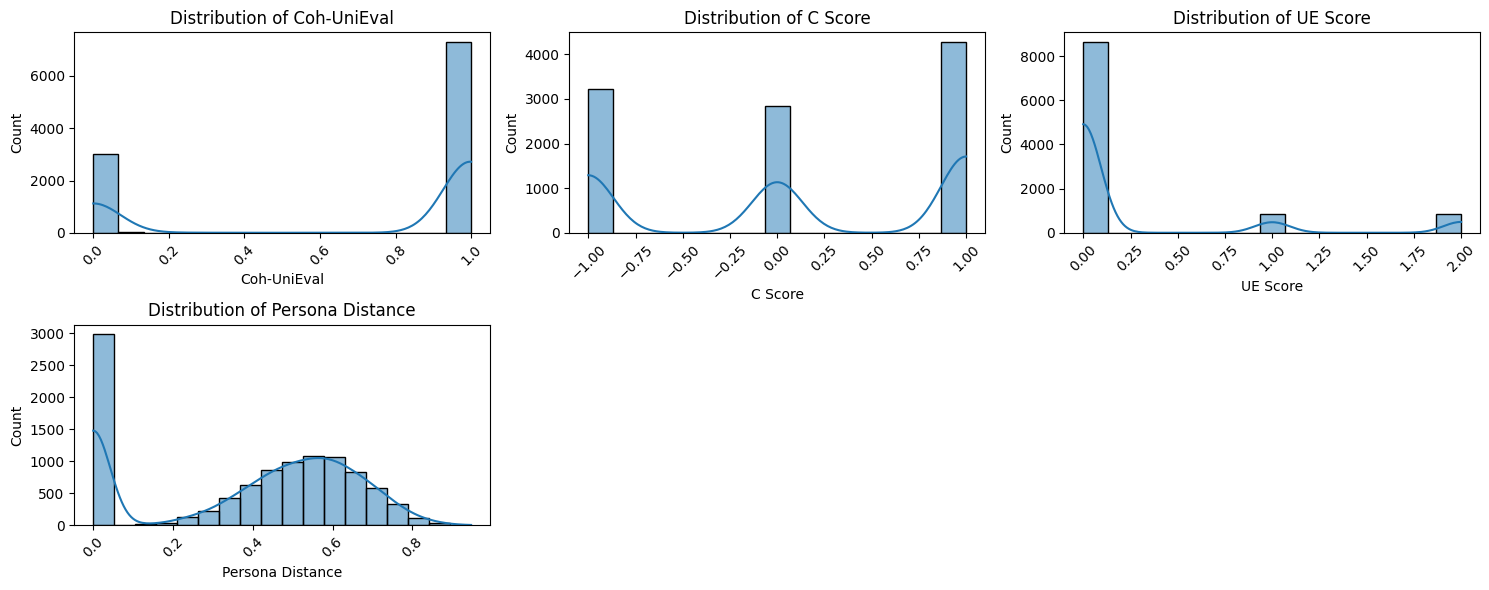

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
def is_valid_json_response(text):
    """
    Checks whether the text is a valid JSON with a single key: "response"
    """
    try:
        obj = json.loads(text)
        return isinstance(obj, dict) and list(obj.keys()) == ["response"]
    except:
        return False

def contains_meta_leak(text):
    """
    Detects phrases that indicate comment, prompt repetition, or format confusion
    """
    leak_patterns = [
        r"Note:",
        r"Let['’]s",
        r"/\*.*?\*/",    # comment blocks
        r"Output format",
        r"Alternatively",
        r"Or",
        r"#",            # markdown or script syntax
    ]
    return any(re.search(p, text, re.IGNORECASE) for p in leak_patterns)

def has_structural_issues(text):
    """
    Flags response if it includes multiple `{}` blocks or has unbalanced quotes/brackets
    """
    return (
        text.count("{") > 1 or
        text.count("}") > 1 or
        text.count('"') % 2 != 0   # unbalanced quotation marks
    )


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

# Compute response length in number of words
df.rename(columns={"gen_response": "response"}, inplace=True)
df["response_length"] = df["response"].str.split().str.len()


# Set your preferred maximum response length
MAX_LEN = 220 if _COT == "-COT" else 110

# Compute length penalty (shorter is better)
df["length_penalty"] = 1.0 - (df["response_length"] / MAX_LEN)
df["length_penalty"] = df["length_penalty"].clip(lower=0.0, upper=1.0)

    
# Prioritizing the Response Length
df["quality_score"] = (
    0.15 * df["Coh-UniEval"] +
    0.15 * df["C Score"] +
    0.15 * df["UE Score"] +
    0.15 * df["Persona Distance"] + 
    0.4 * df["length_penalty"]
)


# # Valid JSON format → 1.0, otherwise 0.0
# df["format_penalty"] = df["response"].apply(lambda r: 1.0 if is_valid_json_response(r) else 0.0)
# # No meta-leakage → 1.0, otherwise 0.0
# df["meta_leak_penalty"] = df["response"].apply(lambda r: 0.0 if contains_meta_leak(r) else 1.0)
# # No structural issues → 1.0, otherwise 0.0
# df["structure_penalty"] = df["response"].apply(lambda r: 0.0 if has_structural_issues(r) else 1.0)


# df["quality_score"] = (
#     0.12 * df["Coh-UniEval"] +
#     0.12 * df["C Score"] +
#     0.12 * df["UE Score"] +
#     0.10 * df["Persona Distance"] + 
#     0.20 * df["length_penalty"] +
#     0.20 * df["format_penalty"] +         # new
#     0.07 * df["meta_leak_penalty"] +      # new
#     0.07 * df["structure_penalty"]        # new
# )
    
# df["quality_score"] = MinMaxScaler().fit_transform(df[["quality_score"]])


print("✅ Added normalized quality score:")
display(df[["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty", "quality_score"]].head())

df.drop(columns=["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty"], inplace=True)

df.drop(columns=["act_response", "response_time", "response_length"], inplace=True)
print(df.shape)

✅ Added normalized quality score:


,Coh-UniEval,C Score,UE Score,Persona Distance,length_penalty,quality_score
0,0.999912,0.5,0.0,0.399985,0.545455,0.503166
1,0.999077,1.0,0.0,0.707204,0.372727,0.555033
2,0.997008,0.5,0.5,0.483180,0.736364,0.666574
3,0.999672,1.0,0.0,0.499546,0.345455,0.513065
4,0.998717,1.0,0.0,0.656254,0.281818,0.510973


(10347, 4)


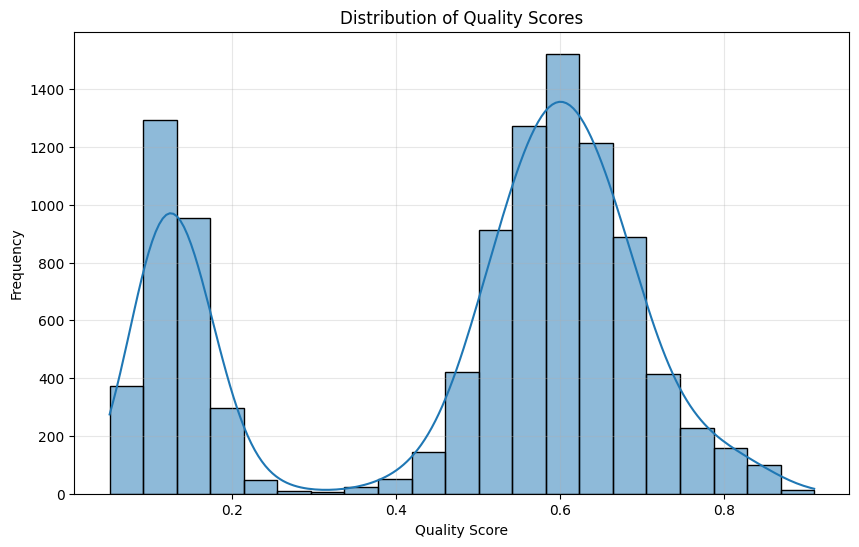

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['quality_score'], kde=True)
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


In [17]:
# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [18]:
# Step 4: Prepare prompt and extract unique pairs

# # Apply to your dataframe
df["prompt"] = df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

# df["prompt"] = df.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)

# Get unique (personas, context) pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")
print("df shape:", df.shape)

df.head(3)


Total unique context-persona pairs: 1500
df shape: (10347, 5)


,personas,context,response,quality_score,prompt
0,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...","Yes, this lighthouse has made appearances on t...",0.503166,I will provide you with a conversation context...
1,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Yes, ski lessons are available at Vail Ski Res...",0.555033,I will provide you with a conversation context...
2,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,The formal garden at Greenmount Homestead feat...,0.666574,I will provide you with a conversation context...


In [19]:
from tqdm import tqdm

# Quantile thresholds
q_low = df["quality_score"].quantile(0.40)
q_high = df["quality_score"].quantile(0.60)

# q_low = df["quality_score"].quantile(0.20)
# q_high = df["quality_score"].quantile(0.60)


# Filter to exclude mid-range responses
eligible_df = df[
    (df["quality_score"] <= q_low) | (df["quality_score"] >= q_high)
]

# Prepare DPO records
dpo_records = []

for _, pair in tqdm(unique_pairs.iterrows(), total=len(unique_pairs)):
    sub_df = eligible_df[
        (eligible_df["personas"] == pair["personas"]) &
        (eligible_df["context"] == pair["context"])
    ]

    high_quality = sub_df[sub_df["quality_score"] >= q_high]
    low_quality = sub_df[sub_df["quality_score"] <= q_low]

    for _, chosen_row in high_quality.iterrows():
        for _, rejected_row in low_quality.iterrows():
            dpo_records.append({
                "prompt": create_dpo_prompt(
                    personas=chosen_row["personas"],
                    context=chosen_row["context"],
                    _COT=_COT  # This variable must be defined earlier
                ),
                "chosen": json.dumps({"response": chosen_row["response"]}),
                "rejected": json.dumps({"response": rejected_row["response"]}),
                "score_chosen": round(chosen_row["quality_score"], 4),
                "score_rejected": round(rejected_row["quality_score"], 4)
            })

print(f"✅ Total DPO records prepared: {len(dpo_records)}")


100%|██████████| 1500/1500 [00:02<00:00, 611.25it/s]

✅ Total DPO records prepared: 9314


In [20]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset to CSV

if SCORING_METHOD == "AVG":
    output_path = f"dpo_avg{_COT}.csv"
else:
    output_path = f"dpo_length_prior{_COT}.csv"  

dpo_weighted_df.to_csv(f"dpo_datasets/{DATASET}_{output_path}", index=False)

print(f" File saved to: {output_path}")

dpo_weighted_df.head(30)

Final weighted DPO dataset shape: (9314, 5)
 File saved to: dpo_length_prior.csv


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""Yes, this lighthouse has made ap...",0.5935,0.5032
1,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""The South Foreland Lighthouse is...",0.5935,0.5201
2,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""I would love to visit the South ...",0.5935,0.4284
3,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""The South Foreland Lighthouse, b...",0.5935,0.1527
4,I will provide you with a conversation context...,"{""response"": ""Yes, South Foreland Lighthouse h...","{""response"": ""Yes, this lighthouse has made ap...",0.6462,0.5032
5,I will provide you with a conversation context...,"{""response"": ""Yes, South Foreland Lighthouse h...","{""response"": ""The South Foreland Lighthouse is...",0.6462,0.5201
6,I will provide you with a conversation context...,"{""response"": ""Yes, South Foreland Lighthouse h...","{""response"": ""I would love to visit the South ...",0.6462,0.4284
7,I will provide you with a conversation context...,"{""response"": ""Yes, South Foreland Lighthouse h...","{""response"": ""The South Foreland Lighthouse, b...",0.6462,0.1527
8,I will provide you with a conversation context...,"{""response"": ""Vail Ski Resort is situated at a...","{""response"": ""provide the personalized natural...",0.5969,0.5058
9,I will provide you with a conversation context...,"{""response"": ""The formal garden at Greenmount ...","{""response"": ""I would love to visit Greenmount...",0.6666,0.1127


# Dataset Concatination

In [19]:
BST = "Blended Skill Talk"
CONVAI = "IT-ConvAI2"
FOCUS = "FoCus"

_COT = ""
# _COT = "-COT"

# SCORING_METHOD = "avg"
SCORING_METHOD = "length_prior"

In [20]:
import pandas as pd

bst_df = pd.read_csv(f"dpo_datasets/{BST}_dpo_{SCORING_METHOD}.csv")
convai_df = pd.read_csv(f"dpo_datasets/{CONVAI}_dpo_{SCORING_METHOD}.csv")
focus_df = pd.read_csv(f"dpo_datasets/{FOCUS}_dpo_{SCORING_METHOD}.csv")

df = pd.concat([bst_df, convai_df], ignore_index=True) 
df.head(3)

,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,I'm sorry to hear that you experience anxiety....,I think it's because you're worried about how ...,0.711,0.116
1,I will provide you with a conversation context...,"Ha ha, that's hilarious! I can imagine my daug...","Oh no, that must've been quite a surprise! I'm...",0.645,0.564
2,I will provide you with a conversation context...,I'm glad to hear that! I can't wait for your s...,"I'm sure it's bittersweet for you, but it's gr...",0.690,0.530


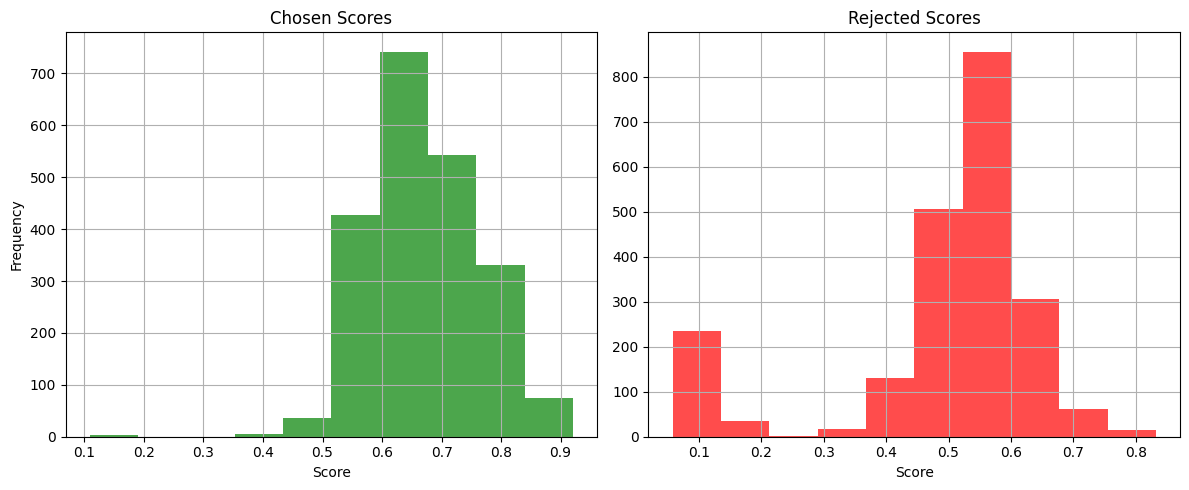

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()


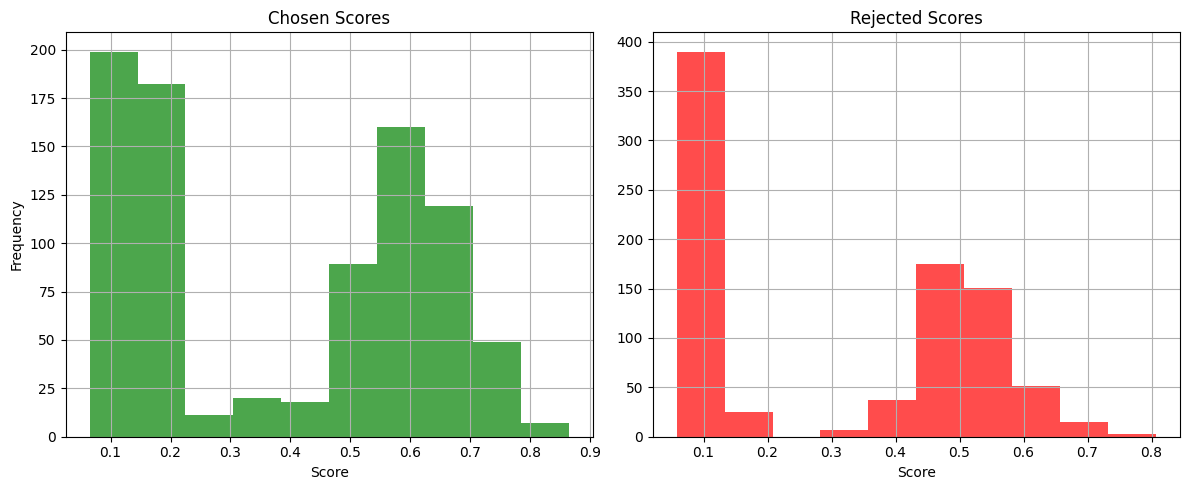

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
focus_df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

focus_df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()